In [296]:
"""
This cell creates waveforms with just a simple afterpulsing+crosstalk model -- only one cross talk event
can be created with uniform probability. Same with afterpulsing. 

Cells below implement a model where the number of cross talk events depends on a borel distribution
"""

position = 0

t0s = [] # an array of all of the positions of the t0s 
dts = [] # an array of all of the delay times between dark count events
xt_t0s = [] # an array of all of the positions of cross talk events
xt_dts = []
ap_t0s = [] # an array of all positions of afterpulsing events 
ap_dts = [] # an array of all of the afterpulse delay times, can check against it later

# Keep sampling until we are outside the waveform 
while position < wf_len: 
    dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distirbution is defined by loc, scale like anything in scipy.stats
    
    # Advance the position by this dt
    position += dt0
    
    # If we're still inside the wf_len, then save it and the delay time 
    # Save the dark counts
    dts.append(dt0)
    t0s.append(position)
    
    # Now see if we get any XTs or APs
    if P_xt >= uniform.rvs(size=1)[0]:
        # The number of XT events is determined by a Borel distribution 
        xt_t0s.append(position)
        xt_dts.append(dt0)
        
    if P_ap >= uniform.rvs(size=1)[0]:
        # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
        dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
        if position + dt_ap <= wf_len:
            ap_t0s.append(position+dt_ap)
            ap_dts.append(dt_ap)
    
    
    
    

# Goal: Create a series of syntehtic waveforms with SiPM characteristics exactly known so that we can test how well sipm_studio recovers the parameters 

The user can set the gain, DCR, AP and XT probabilities and this code should simulate a series of waveforms with those parameters. The individual pulses can be created using the Duara model for the SiPM electronics response. The timing and character of the pulses can be set by sampling a Poisson distribution. Here's an outline of how the code should work 

1. The user specifies the gain, DCR, AP and XT probabilities, as well as the number of waveforms and length of each waveform 
2. We start the waveform with a pulse, and then sample an Exponential distribution for the inter-event time from that pulse to the next one. Recall that for poisson processes, the interevent times are exponentially distributed
3. Each time a pulse is registered, another distribution (uniform) is sampled to see if this event creates a direct cross talk event, and/or if there is an afterpulsing event. Maybe take a Borel distribution to find out how many DiCT events there are. The number of afterpulses is determined by a binomial distribution from number of direct cross talk events. The afterpulsing events are then distributed among the recovery time of the cell with a Poisson distribution, and a random Gaussian distribution around 0.5 p.e. draws their amplitude. 
4. Each pulse's amplitude is multiplied by a scaling drawn from a Gaussian with some sigma, distributed around unity 
5. All of the pulses are then added together. (I guess that means each pulse has the same waveform length, we just roll where the pulse starts and stops in the range)

We first go through a waveform and find all of the t0s for each of these three types of pulses, and then in a later step, we modify the amplitude of these pulses by drawing them from either a Gaussian (DCR + AP) or Borel (DiCT) distribution. 

If this simulation works well enough, we could use Iminuit to create a function that will just run this simulation with a variety of parameters until we reproduce a measured dt/QPE spectrum....


In [363]:
gain = 1.7e6 # typical gain from a SiPM 
DCR = 300 # this is in counts per second, let's convert to samples using the sampling rate of the digitizer

P_xt = 0.1 # these are made up, but probability that a DC creates direct cross talk
avg_xt_num = 5 # average number of direct cross talk discharges per DC


P_ap = 0.05 # also made up, probability for afterpulsing 
AP_rate = 30 # no idea, just again assume exponential inter-time from the main DC, this is also the cell recovery time!
alpha = 0.9 # probability that Geiger discharge (from DC + XT events) causes an AP

sampling_rate = 1 # 2ns per sample 
DCR /= sampling_rate # DCR in counts/sample


In [364]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import poisson, norm, binom, uniform, expon

In [365]:
from scipy.stats import rv_continuous
from scipy.special import gamma 

from scipy.stats import rv_continuous, rv_discrete
from scipy.special import gamma, gammaln

class borel_gen(rv_discrete): 
    """
    Create a class with methods that compute a Borel distribution 
    """
    
    def _pmf(self, n, mu):
        r"""
        Computes the pmf for a Borel distribution $P(n, \mu) = \frac{e^{-\mu n}(\mu n)^{n-1}}{n!}$
        """
        
        return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
    def _logpmf(self, n, mu):
        r"""
        Computes the log of pmf for a Borel distribution $P(n, \mu) = -\mu n + (n-1)\log(\mu n)-\log(n!)$
        """
        return -mu*n + (n-1)*np.log(mu*n) - gammaln(n+1)

    
borel = borel_gen(a=1, name='borel')

In [376]:
wf_len = 1e8

In [377]:
"""
TODO: we might not need to sample from the uniform distribution for AP, we might just straight up sample the binomial
as a 0 count from the binomial distribution is possible -- see if this way we can recover the afterpulsing probability
"""

position = 0
mu = 1-(1/avg_xt_num) # shape parameter of the Borel distribution for XT

t0s = [] # an array of all of the positions of the t0s 
dts = [] # an array of all of the delay times between dark count events

xt_t0s = [] # an array of all of the positions of cross talk events
xt_dts = [] 
num_xts = [] # an array containing the number of cross talk discharges 

ap_t0s = [] # an array of all positions of afterpulsing events 
ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
num_xts_per_ap = []

# Keep sampling until we are outside the waveform 
while position < wf_len: 
    dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distirbution is defined by loc, scale like anything in scipy.stats
    
    # Advance the position by this dt
    position += dt0
    
    # If we're still inside the wf_len, then save it and the delay time 
    # Save the dark counts
    dts.append(dt0)
    t0s.append(position)
    
    # Now see if we get any XTs or APs
    num = 1 # set default to the 1 DC already created
    if P_xt >= uniform.rvs(size=1)[0]:
        # The number of XT events is determined by a Borel distribution 
        num += borel.rvs(mu, size=1)[0]
        num_xts.append(num)
        xt_t0s.append(position)
        xt_dts.append(dt0)
        
    num_ap = 0
    if P_ap >= uniform.rvs(size=1)[0]:
        # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
        while num_ap == 0: # make sure we don't get 0 afterpulses 
            num_ap = binom.rvs(num, alpha, size=1)[0]
        num_aps.append(num_ap)
        for i in range(num_ap):
            num_xts_per_ap.append(num)
            dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
            if position + dt_ap <= wf_len:
                ap_t0s.append(position+dt_ap)
                ap_dts.append(dt_ap)

    
    
    

/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_99429/3824198960.py:17: RuntimeWarning: overflow encountered in multiply
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_99429/3824198960.py:17: RuntimeWarning: overflow encountered in power
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_99429/3824198960.py:17: RuntimeWarning: invalid value encountered in true_divide
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))


9.536269067963947e-05


<Figure size 640x480 with 0 Axes>

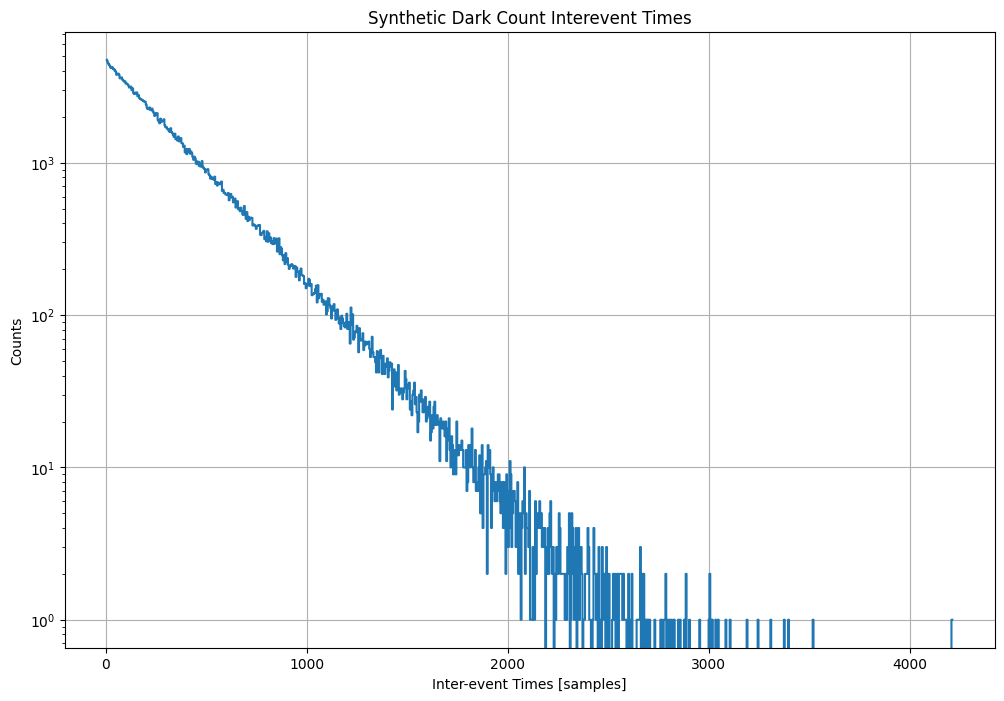

In [378]:
print(np.amin(dts))
n, bins, _ = plt.hist(dts, bins = 1000)
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Dark Count Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>

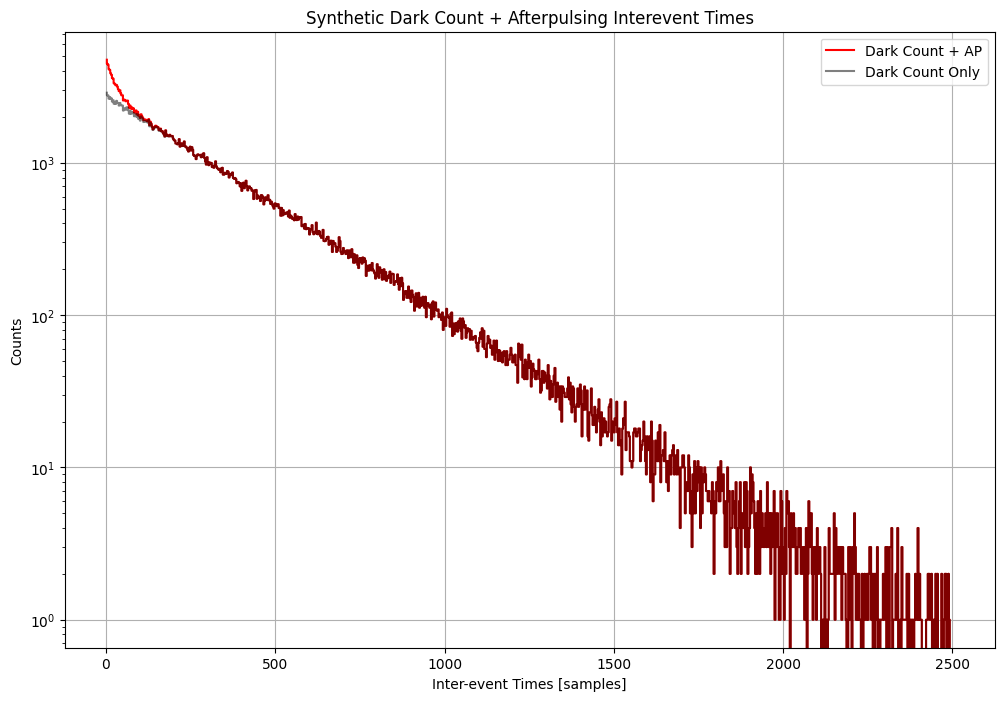

In [379]:
all_dts = np.append(dts, ap_dts)
n_ap, bins_ap, _ = plt.hist(all_dts, bins = 1000, range = [0,2500])
n, bins, _ = plt.hist(dts, bins = 1000, range = [0,2500])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins_ap[1:], n_ap, label = 'Dark Count + AP', c='r')
plt.step(bins[1:], n, label = 'Dark Count Only', alpha= 0.5, c='k')
plt.title("Synthetic Dark Count + Afterpulsing Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

## Now create the code that will modify the amplitudes
Eventually use these amplitudes to modify the actual modeled SiPM pulses put into the waveform 

In [380]:
mu_dcr = 1
# sigma_dcr = 0.1

sigma_detector = 0.2


amps = norm.rvs(mu_dcr, sigma_detector, size=len(t0s)) # dark counts have amps within 0.1 sigma of 1 

# Convolve the Borel XTs with a Gaussian detector response 
xt_amps = norm.rvs(1, sigma_dcr, size=len(xt_t0s))
xt_amps = xt_amps*np.array(num_xts)

# Afterpulses have an amplitude that varies with ratio of the delay time from primary dcr and the recovery time 
def ap_recovery(dts, recovery_time):
    return 1-np.exp(-1*np.array(dts)/recovery_time)

ap_amps = ap_recovery(ap_dts, AP_rate)
ap_amps = np.array(num_xts_per_ap) * ap_amps
# maybe multiply them by the cross talk height?
# then convolve them with a Gaussian detector response 
ap_amps = ap_amps * norm.rvs(1, sigma_detector, size=len(ap_t0s)) 

In [381]:
all_amps = np.append(amps, xt_amps)
all_amps = np.append(all_amps, ap_amps )

<Figure size 640x480 with 0 Axes>

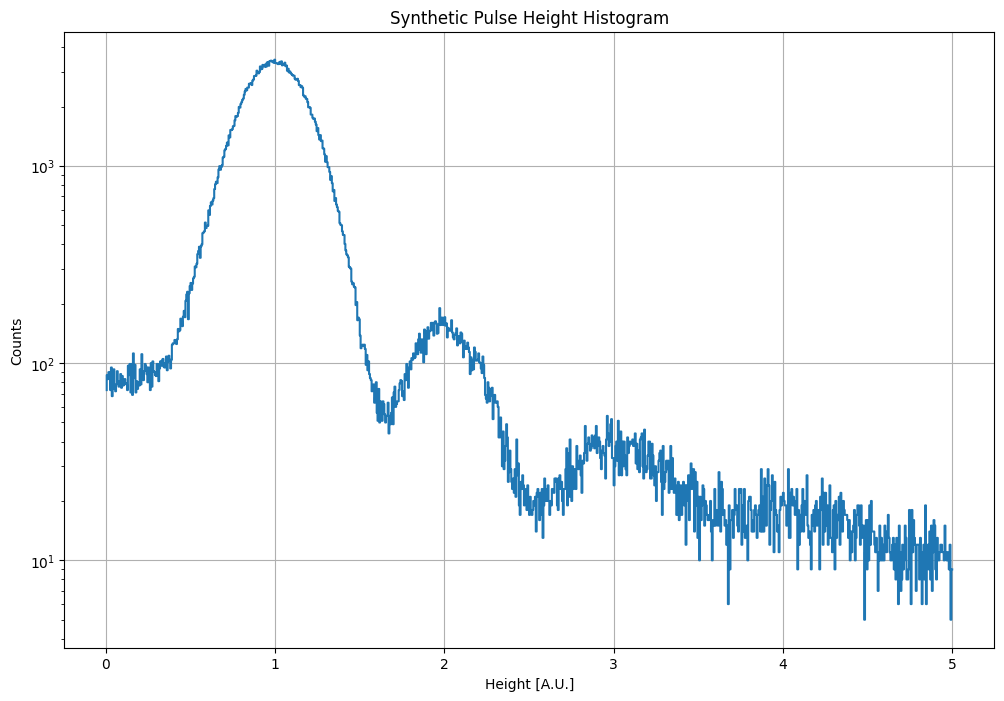

In [386]:
n, bins, _ = plt.hist(all_amps, bins = 1000, range = [0,5])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Height [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

In [387]:
print(len(ap_amps)/len(amps))
print(len(xt_amps)/len(amps))

0.07189328397005748
0.09949484780825252


In [388]:
print("percent error on afterpulse is", 100*(np.abs(len(ap_amps)/len(amps)-P_ap)/P_ap))
print("percent error on cross talk is", 100*(np.abs(len(xt_amps)/len(amps) - P_xt)/P_xt))

percent error on afterpulse is 43.786567940114956
percent error on cross talk is 0.5051521917474877


## Make the 2d inter-event time plot 


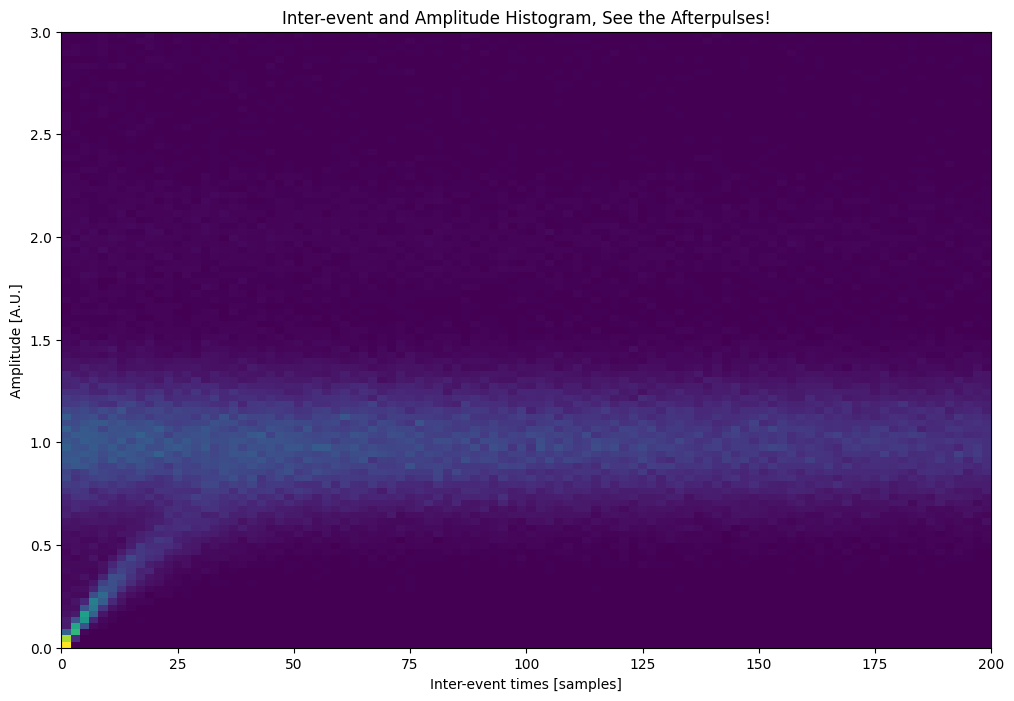

In [385]:
all_dts = np.append(dts, xt_dts)
all_dts = np.append(all_dts, ap_dts)

plt.figure(figsize=(12, 8))
plt.hist2d(all_dts, all_amps, range = [[0, 200], [0,3]], bins=100)
plt.title("Inter-event and Amplitude Histogram, See the Afterpulses!")
plt.xlabel("Inter-event times [samples]")
plt.ylabel("Amplitude [A.U.]")
plt.show()